In [1]:
#!pip install gym
#!pip install tensorflow[and-cuda]
#!pip install pygame

In [2]:
# set tf warning level to 2 ....shows errors but not warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#tf.__version__

In [3]:
from gym import Env
from gym.spaces import Discrete, Box

import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
#tf.config.run_functions_eagerly(True)
#print(tf.config.functions_run_eagerly())
from tensorflow import keras
from tensorflow.keras.models import load_model


#from rl.agents import DQNAgent
#from rl.policy import BoltzmannQPolicy
#from rl.memory import SequentialMemory


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# tyr legacy adam due to numpy error
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import random

import pygame

# Set the random seed
seed_value = 40
np.random.seed(seed_value)
random.seed(seed_value)

In [4]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1727288308.580735  231901 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727288308.604959  231901 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727288308.606921  231901 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Create Environment

In [5]:
# ubuntu
df_normalised = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_12_23_sec_minmax.csv", index_col='time_in_seconds')
data_array = df_normalised.to_numpy()
#df_normalised.shape

In [6]:
df_normalised

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,P602
time_in_seconds,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.990606,0.5,1.0,1.000000,0.128753,0.498588,0.769136,1.0,0.0,...,0.686274,0.566850,0.541283,0.429823,0.344541,0.390927,0.238806,0.402412,0.000000,0.0
1,0.0,0.989536,0.5,1.0,1.000000,0.128753,0.499496,0.863706,1.0,1.0,...,0.686274,0.566850,0.421003,0.429823,0.546218,0.382286,0.238806,0.402412,0.000000,0.0
2,0.0,0.989536,0.5,1.0,1.000000,0.128753,0.501614,0.916761,1.0,1.0,...,0.686274,0.566850,0.408771,0.429823,0.546218,0.360690,0.238806,0.400006,0.000000,0.0
3,0.0,0.989417,0.5,1.0,0.966105,0.125893,0.504035,0.952045,1.0,1.0,...,0.686274,0.566850,0.460754,0.622810,0.546218,0.360690,0.238806,0.378318,0.000000,0.0
4,0.0,0.988585,0.5,1.0,0.966105,0.125893,0.507466,0.974452,1.0,1.0,...,0.686274,0.566850,0.580023,0.622810,0.546218,0.388771,0.238806,0.378318,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.0,0.984067,0.5,0.0,0.105092,0.143060,0.049132,0.000000,0.5,0.0,...,0.274513,0.633712,0.428134,0.429823,0.319327,0.449245,0.268657,0.431319,0.000037,0.0
86396,0.0,0.983948,0.5,0.0,0.105092,0.143060,0.049132,0.000000,0.5,0.0,...,0.274513,0.633712,0.405708,0.429823,0.319327,0.421165,0.268657,0.431319,0.000037,0.0
86397,0.0,0.983591,0.5,0.0,0.105092,0.143060,0.048931,0.000000,0.5,0.0,...,0.274513,0.598830,0.509681,0.429823,0.319327,0.421165,0.268657,0.395178,0.000037,0.0


In [7]:
data_array[35].max()

1.0

In [8]:
component_pos = {key: idx for idx, key in enumerate(df_normalised.columns)}
component_pos.items()

dict_items([('FIT101', 0), ('LIT101', 1), ('MV101', 2), ('P101', 3), ('AIT201', 4), ('AIT202', 5), ('AIT203', 6), ('FIT201', 7), ('MV201', 8), ('P203', 9), ('P205', 10), ('DPIT301', 11), ('FIT301', 12), ('LIT301', 13), ('MV301', 14), ('MV302', 15), ('MV303', 16), ('MV304', 17), ('P301', 18), ('P302', 19), ('AIT401', 20), ('AIT402', 21), ('FIT401', 22), ('LIT401', 23), ('AIT501', 24), ('AIT502', 25), ('AIT503', 26), ('AIT504', 27), ('FIT501', 28), ('FIT502', 29), ('FIT503', 30), ('FIT504', 31), ('PIT501', 32), ('PIT502', 33), ('PIT503', 34), ('FIT601', 35), ('P602', 36)])

In [9]:
data_array[component_pos['LIT101']]

array([0.        , 0.9895364 , 0.5       , 1.        , 1.        ,
       0.12875348, 0.49949565, 0.86370641, 1.        , 1.        ,
       0.        , 0.97655405, 0.93638966, 0.02859152, 0.5       ,
       1.        , 0.5       , 0.5       , 0.        , 1.        ,
       0.        , 0.78048858, 0.52452306, 0.18279767, 0.44860876,
       0.78728599, 0.65201404, 0.68627361, 0.56685038, 0.42100321,
       0.4298233 , 0.54621783, 0.38228633, 0.23880613, 0.40241243,
       0.        , 0.        ])

In [10]:
# test lstm swat simulator
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')
#swat_lstm = tf.keras.models.load_model('best_model.keras')
#model_window = 20
swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
model_window = 100

I0000 00:00:1727288309.198639  231901 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727288309.200685  231901 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727288309.202594  231901 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727288309.295397  231901 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Agent for single window

In [11]:
# Reshape the input from data_array to add the batch dimension
#reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 99, 37)
# round to make observation space workable
#reshaped_input = np.round(reshaped_input, 2)


#reshaped_input.shape
#reshaped_input[0,-1,]

# get last row
one_state = reshaped_input[0,-1,:]
one_state.shape

for _ in range(10):
    prediction = swat_lstm.predict(reshaped_input)
    # Print shape
    #print(prediction.shape)
    # drop first row from input, add prediction with new axis padded to match shape
    reshaped_input = np.concatenate((reshaped_input[:, 1:, :], prediction[:, np.newaxis, :]), axis=1)
    #print(reshaped_input.shape)


prediction = swat_lstm.predict(reshaped_input)

def update_state(state_history, action_input):
    # add action to previous states
    model_input = np.concatenate((state_history[:, 1:, :], action_input[:, np.newaxis, :]), axis=1)
    # predict
    new_state = swat_lstm.predict(model_input)
    return new_state, model_input
    


new_state, model_input = update_state(reshaped_input, prediction) 
new_state.shape

#new_state[0]=10
#new_state

In [12]:
#model_input.shape

In [13]:
#reshaped_input.shape

In [14]:
data_array.shape

(86400, 37)

component_pos['MV201']

In [26]:
# inherit from gym env
class SwatEnv(Env):
    def __init__(self, data_array, window_size=99, episode_length=100):
        print('init reached')
        # 0: both off, 1: MV101 On MV201 Off, 2: MV101 Off MV201 On, 3: both on
        self.action_space = Discrete(4)
        self.episode_length = episode_length
        
        # make sure array is 3 dims for model input
        if len(data_array.shape) == 2:
            # Add a batch dimension to make it (1, time_steps, features)
            data_array = data_array[np.newaxis, :, :]
        
        # swat value array, only position 1 used as lit101 level. 2.d.p 
        self.observation_space = Box(
            # round to 2 d.p. to act as binning values
            low=np.round(np.full((1, 37), 0.00), 2),  # 1x37 array with all elements set to 0.00
            high=np.round(np.full((1, 37), 100.00), 2),  # 1x37 array with all elements set to 100.00
            dtype=np.float32  # Specify float with two decimal places precision
        )
        
        # Initialise data params
        self.data_array = data_array
        self.window_size = window_size 
        
        # use reset to intialise the data window to use 
        self.reset(data_array)      
        
        # state history is 98 time steps preceding
        #self.state_history = model_input
        # set start state as last row in modelinput
        #elf.state = self.state_history [0,-1,:]
        
        # set shower length
        self.episode_length = episode_length
        
        self.lit101_value_record = []
    
    # Override inherited method  
    def sample_observation(self):
        return np.round(self.observation_space.sample(), 2)

        
    def update_state(self, state_history, action_input):
        # Ensure action_input is reshaped to 1x37 array
        action_input = action_input.reshape(1, -1)
        
        # add action to previous states
        model_input = np.concatenate((state_history[:, 1:, :], action_input[:, np.newaxis, :]), axis=1)
        # predict
        new_state = swat_lstm.predict(model_input)
        new_state = np.round(new_state, 2)
        
        # prob don't use as new window wanted
        # update history with new state
        #self.state_history = np.concatenate((state_history[:, 1:, :], new_state[:, np.newaxis, :]), axis=1)
        
        # flatten new_state from (1,37) to (37,)
        new_state = new_state.flatten()
        
        return new_state
        
    def step(self, action):
        #print(f'step reached {action}')
        
        # copy current state
        action_input = self.state.copy() 
        
        # MV101 
        if action == 0:
            ## MV101 and MV201 off         
            action_input[component_pos['MV101']] = 0
            action_input[component_pos['MV201']] = 0
            
        elif action == 1:
            # MV101 On, MV201 Off
            action_input[component_pos['MV101']] = 1
            action_input[component_pos['MV201']] = 0
        elif action == 2:
            # MV101 Off, MV201 On
            action_input[component_pos['MV101']] = 0
            action_input[component_pos['MV201']] = 1
        elif action == 3:
            # Both MV101 and MV201 On
            action_input[component_pos['MV101']] = 1
            action_input[component_pos['MV201']] = 1
        
        new_state = self.update_state(self.state_history, action_input)
        # test with no actions
        #new_state = self.update_state(self.state_history, self.state.copy())
        
        
        #print(new_state.shape, self.state.shape)
        
        #record lit101 state
        #self.lit101_value_record.append((np.round(new_state[component_pos['LIT101']], 2)))
        # get change in value for plotting
        
        self.lit101_value_record.append(np.round(new_state[component_pos['LIT101']]-self.state[component_pos['LIT101']], 2))

                                     
        # check for increase
        if new_state[component_pos['LIT101']] > self.state[component_pos['LIT101']]:
            reward = new_state[component_pos['LIT101']] - self.state[component_pos['LIT101']]
        elif new_state[component_pos['LIT101']] == self.state[component_pos['LIT101']]:
            reward = -1
        elif new_state[component_pos['LIT101']] < self.state[component_pos['LIT101']]:
            reward = self.state[component_pos['LIT101']] - new_state[component_pos['LIT101']]
            
        print(f'lit:{self.state[component_pos['LIT101']], new_state[component_pos['LIT101']]} reward:{reward}')
        
        # prob not needed as should be reset to new window
        # update state
        self.state = new_state
    
        # reduce episode_length
        self.episode_length = self.episode_length - 1
        
        # Check if episode is done
        if self.episode_length <= 0:
            done = True
        else:
            done = False         
        
        return self.state, reward, self.lit101_value_record, done #, info

    def reset(self, data_array):
        # state history is 98 time steps preceding
        #self.state_history = model_input
        
        # Randomly select new window from data_array for each episode
        start_idx = np.random.randint(0, data_array.shape[1] - self.window_size)
        self.state_history = data_array[:, start_idx:start_idx + self.window_size, :]
        # Set the start state as the last row in the selected window
        self.state = self.state_history[0, -1, :]
        
        # reset episode
        #self.episode_length = episode_length
        # reset value record
        self.lit101_value_record = []
        return self.state
        
    #def render(self):
        # for vis ie pygame
        #pass
    def render(self, screen, font):
        '''
        screen.fill((255, 255, 255))  # Fill the screen with white

        # Draw the temperature meter
        pygame.draw.rect(screen, (0, 0, 255), (100, 150, 50, 200))  # Blue background
        temp_height = (self.state - 0) / 100 * 200  # Scale temp to meter height
        pygame.draw.rect(screen, (255, 0, 0), (100, 350 - temp_height, 50, temp_height))  # Red temperature

        # Display temperature value
        temp_text = font.render(f'Temp: {self.state}°C', True, (0, 0, 0))
        screen.blit(temp_text, (200, 150))

        # Display shower length
        shower_text = font.render(f'Shower Time: {self.shower_length}s', True, (0, 0, 0))
        screen.blit(shower_text, (200, 200))
        '''
        pass

        



def main():
    # Initialize pygame
    pygame.init()
    screen = pygame.display.set_mode((600, 400))
    pygame.display.set_caption("SWAT Environment Visualization")

    # Font for rendering text
    font = pygame.font.SysFont('Arial', 24)

    # Create the environment
    env = SwatEnv()

    # Initialize game loop variables
    running = True
    clock = pygame.time.Clock()

    state = env.reset()  # Initialize environment state

    while running:
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Action logic (can be random for testing purposes)
        action = random.randint(0, 2)  # Replace with your agent's action

        # Perform step
        state, reward, done, info = env.step(action)

        # Render the environment
        env.render(screen, font)

        # Update the display
        pygame.display.flip()

        # End if the shower is done
        if done:
            state = env.reset()

        # Control frame rate (optional)
        clock.tick(30)  # 30 FPS

    pygame.quit()

if __name__ == "__main__":
    main()


In [27]:
#reshaped_input[0,11,]

In [28]:
# sample from action space
#env.action_space.sample()

In [29]:
#env.observation_space.sample()

In [30]:
# shown as high precision but actually 2 dp....
#sampled_obs = env.observation_space.sample()
#sampled_obs_rnd = np.round(sampled_obs, 2)
#sampled_obs_rnd

print(env.state.shape)

env = SwatEnv(reshaped_input)# store lit101 values form each episode

lit101_dict = {}

episodes = 5
for episode in range(1, episodes+1):
    
    env.reset(reshaped_input)
    state = env.state
    done = False
    score = 0 
    
    while not done:
        #env.render()
        # sample from 4 possible states 
        #action = env.action_space.sample()
        
        # just activate MV101 to see if response from lstm model is linear
        action = 1
        
        
        # pass 1 x 37 array of SWat states
        #action = one_state
        #n_state, reward, done, info = env.step(action)
        n_state, reward, done = env.step(action)
        print(n_state)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    # add this episodes list of values
    lit101_dict[episode] = env.lit101_value_record

for key, value in lit101_dict.items():
    plt.plot(value, label=key)

plt.legend()    
plt.show()

# Test with multiple start points

In [31]:
#start_idxs = [np.random.randint(0, 1000) for n in range(5)]
#start_idxs

In [32]:
data_array.shape

(86400, 37)

In [51]:
def run_random_trials(environment, data_array, window_size , episode_length, number_of_trials):
    ''' Function to set up each trial with a random window'''

    values_dict = {}
    input_windows = {}
    
    
    data_length = data_array.shape[0]
    window_size = model_window - 1
    
    values_dict = {}
    input_windows = {}
    
    
    for trial in range(number_of_trials):
    
        values_dict[trial] = run_trial(environment,episode_length, number_of_episodes=1)
        
    return values_dict, input_windows
    
def run_trial(environment, data_array, window_size, episode_length):
    '''
    Function to run agent with a given starting point of a data window from the data_set
    :param environment: SWaTEnv
    :param model_input_window: Random slice of SWaT data in format for LSTM (1,19,37)
    :param number_of_episodes: Times to repeat
    :return: 
    '''
    
    # make sure array is 3 dims for model input
    if len(data_array.shape) == 2:
        # Add a batch dimension to make it (1, time_steps, features)
        data_array = data_array[np.newaxis, :, :]
    this_env = environment(data_array, window_size, episode_length)
        
    # store lit101 values form each episode
    #lit101_list = []
    
    episodes = episode_length
    for episode in range(1, episodes+1):
        
        this_env.reset(data_array)
        state = this_env.state
        done = False
        score = 0 
        
        while not done:
            #env.render()
            # sample from 4 possible states 
            #action = this_env.action_space.sample()
            
            # just activate MV101 to see if response from lstm model is linear
            action = 1
            
            # pass 1 x 37 array of SWat states
            #action = one_state
            #n_state, reward, done, info = env.step(action)
            n_state, reward, value_change, done = this_env.step(action)
            print(n_state)
            score+=reward
        print('Episode:{} Score:{}'.format(episode, score))
        # add this episodes list of values
        lit101_list = this_env.lit101_value_record
        
    return lit101_list
    
    
    #return input_windows


In [52]:
lit101_list = []
for _ in range(200):
    lit101_li = run_trial(SwatEnv,data_array,model_window,1)
    lit101_list.append(lit101_li)

init reached
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
lit:(0.1414982686373291, -0.19) reward:0.33149826625314327
[ 0.84 -0.19  0.83  0.47 -0.67 -0.16 -0.35  0.56  0.53  0.57  1.22  0.72
  0.59  1.09  0.23  0.87  0.23 -0.12  0.1   0.63  0.71  0.92  0.4   0.81
 -0.77  1.03  0.09  0.86  0.41  0.21  0.06 -0.45 -0.14  0.76 -0.09  0.01
  0.02]
Episode:1 Score:0.33149826625314327
init reached
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
lit:(0.0338884215443251, -0.48) reward:0.5138884108154891
[ 0.82 -0.48  0.78  0.45  0.39  0.99  0.36  0.48  0.48  0.5   1.05  0.62
  0.47  0.76  0.24  0.81  0.51  0.08 -0.15  0.54 -0.62 -0.02  0.25  0.49
  0.29  0.15  0.95  1.49  0.21  0.06  0.19 -0.17  0.11  0.02  0.17  0.07
  0.03]
Episode:1 Score:0.5138884108154891
init reached
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
lit:(0.989298600460384, 0.74) reward:0.24929859092364082
[ 0.11  0.74  0.13  0.46  0.5  -0.08 -0.03  0.47  0.46  0.49  0.64  0.69
  0.55  0.76  0.08  0.8  -0.11 -0.18 -0.04  0.66 -0.66 -0.18  0.29  0.17
  

/home/loz/Documents/GitHub/MSc-Project/venv/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
lit:(0.0625447381024288, -0.25) reward:0.3125447381024288
[ 0.75 -0.25  0.7   0.47  0.39  0.11  0.34  0.49  0.49  0.51  0.57  0.67
  0.5   0.92  0.14  0.79  0.46  0.12 -0.11  0.54 -0.48  0.08  0.12  0.47
  0.11  0.2   0.91  1.48  0.09  0.07  0.23 -0.1   0.18 -0.16  0.22 -0.02
 -0.12]
Episode:1 Score:0.3125447381024288
init reached
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
lit:(0.0434008440071163, -0.22) reward:0.2634008428150234
[ 0.85 -0.22  0.82  0.44 -0.35 -0.21 -0.3   0.47  0.48  0.49  1.12  0.55
  0.48  0.85  0.18  0.71  0.21  0.01 -0.14  0.59  0.29  0.68  0.53  0.35
 -0.41  0.91  0.16  1.1   0.52  0.19 -0.1  -0.3  -0.38  0.93 -0.31  0.14
 -0.01]
Episode:1 Score:0.2634008428150234
init reached
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
lit:(0.0694411080721093, -0.29) reward:0.359441099727459
[ 0.76 -0.29  0.73  0.49  0.5   0.12  0.59  0.5   0.51  0.52  0.46  0.67
  0.48  0.93  0.19  0.81  0.48  0.12 -0.11  0.53 -0.48  0.14  0.17  0.64
  0.    0.22  1.0

In [53]:
lit101_list

[[-0.33],
 [-0.51],
 [-0.25],
 [-0.4],
 [-0.3],
 [-0.31],
 [-0.26],
 [-0.36],
 [-0.32],
 [-0.18],
 [-0.38],
 [-0.27],
 [-0.42],
 [-0.23],
 [-0.39],
 [-0.37],
 [-0.3],
 [-0.2],
 [-0.2],
 [-0.22],
 [-0.45],
 [-0.54],
 [-0.33],
 [-0.23],
 [-0.23],
 [0.09],
 [-0.25],
 [-0.48],
 [-0.18],
 [-0.37],
 [-0.43],
 [-0.33],
 [-0.42],
 [-0.12],
 [-0.21],
 [-0.4],
 [-0.47],
 [-0.39],
 [-0.26],
 [-0.2],
 [-0.2],
 [-0.23],
 [-0.28],
 [-0.13],
 [-0.43],
 [-0.36],
 [-0.33],
 [-0.22],
 [-0.39],
 [-0.42],
 [-0.4],
 [-0.21],
 [-0.09],
 [-0.41],
 [-0.42],
 [-0.4],
 [-0.25],
 [-0.27],
 [-0.16],
 [-0.32],
 [-0.23],
 [-0.26],
 [-0.4],
 [-0.39],
 [-0.13],
 [-0.34],
 [-0.44],
 [-0.41],
 [-0.31],
 [-0.44],
 [-0.41],
 [-0.26],
 [-0.2],
 [-0.14],
 [-0.41],
 [-0.22],
 [-0.08],
 [-0.4],
 [-0.13],
 [-0.32],
 [-0.35],
 [-0.2],
 [-0.23],
 [-0.15],
 [-0.25],
 [-0.48],
 [-0.49],
 [-0.23],
 [-0.44],
 [-0.44],
 [-0.12],
 [-0.33],
 [-0.42],
 [-0.18],
 [-0.32],
 [-0.36],
 [-0.24],
 [-0.12],
 [-0.25],
 [-0.31],
 [-0.17],
 [-0.

In [ ]:
self.lit101_value_record.

In [77]:
values_dict, input_windows = run_random_trials(data_array, model_window, SwatEnv,200, 5)


AttributeError: 'int' object has no attribute 'shape'

In [67]:
values_dict

{0: [0.09,
  -0.29,
  -0.54,
  -0.71,
  -0.82,
  -0.89,
  -0.93,
  -0.95,
  -0.94,
  -0.91,
  -0.89,
  -0.87,
  -0.85,
  -0.83,
  -0.81,
  -0.79,
  -0.77,
  -0.75,
  -0.73,
  -0.7,
  -0.68,
  -0.65,
  -0.62,
  -0.59,
  -0.56,
  -0.53,
  -0.49,
  -0.45,
  -0.4,
  -0.35,
  -0.29,
  -0.22,
  -0.14,
  -0.04,
  0.07,
  0.2,
  0.36,
  0.55,
  0.77,
  1.02,
  1.29,
  1.56,
  1.83,
  2.08,
  2.3,
  2.46,
  2.51,
  2.49,
  2.44,
  2.39,
  2.35,
  2.33,
  2.33,
  2.34,
  2.34,
  2.33,
  2.31,
  2.28,
  2.25,
  2.22,
  2.2,
  2.18,
  2.16,
  2.15,
  2.14,
  2.14,
  2.14,
  2.14,
  2.14,
  2.14,
  2.14,
  2.15,
  2.16,
  2.17,
  2.19,
  2.21,
  2.24,
  2.27,
  2.3,
  2.33,
  2.36,
  2.39,
  2.41,
  2.43,
  2.44,
  2.44,
  2.42,
  2.39,
  2.33,
  2.25,
  2.15,
  2.09,
  2.09,
  2.12,
  2.15,
  2.18,
  2.19,
  2.18,
  2.14,
  2.11,
  2.06,
  2.05,
  2.0,
  2.0,
  1.95,
  1.97,
  1.93,
  1.95,
  1.92,
  1.93,
  1.9,
  1.91,
  1.89,
  1.9,
  1.89,
  1.89,
  1.89,
  1.88,
  1.89,
  1.87,
  1.9,
  1.87,

In [68]:
input_windows.keys()

dict_keys([0, 1, 2, 3, 4])

In [69]:
trial_window = input_windows[0]

trial_window[0,-1,36]


0.0

In [70]:
# final value for lit
for key,window in input_windows.items():
    print(window[0,-1,:][component_pos['LIT101']])

0.0872769759208664
0.4053509118166749
0.0870394834295975
0.978121307165942
0.0617123026866035


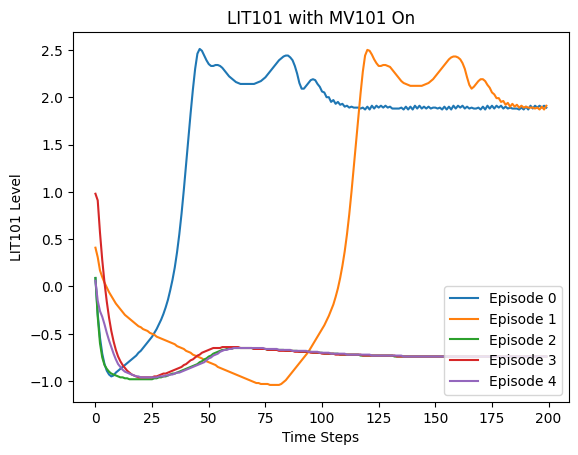

In [72]:
for key, value in values_dict.items():

    #for item in value:
    plt.plot(value, label=f'Episode {key}')

plt.xlabel('Time Steps')
plt.ylabel('LIT101 Level')
plt.title('LIT101 with MV101 On')
plt.legend(loc='lower right')
plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/MV101_held_high.jpeg')
#plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/LIT101_no_actions.jpeg')
plt.show()




# Create Deep Policy Table

# Create Deep Learning Model#

In [28]:
states = env.observation_space.shape
actions = env.action_space.n

NameError: name 'env' is not defined

In [24]:
states

(1, 37)

In [25]:
actions

4

In [26]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    #model.add(Dense(24, activation='relu', input_shape=(1,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [27]:
#del model

In [28]:
model = build_model(states, actions)

/home/loz/Documents/GitHub/MSc-Project/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 24)          │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 24)          │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 4)           │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,612 (6.30 KB)

 Trainable params: 1,612 (6.30 KB)

 Non-trainable params: 0 (0.00 B)

# Build Agent wit Keras-RL

In [30]:
#@tf.function(reduce_retracing=True)
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [31]:
dqn = build_agent(model, actions)

NameError: name 'BoltzmannQPolicy' is not defined

In [41]:
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [42]:


dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)


Training for 5000 steps ...
Interval 1 (0 steps performed)
 1423/10000 [===>..........................] - ETA: 1:36 - reward: -0.5264done, took 16.064 seconds


In [23]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 10.000, steps: 60
Episode 2: reward: 16.000, steps: 60
Episode 3: reward: 6.000, steps: 60
Episode 4: reward: 8.000, steps: 60
Episode 5: reward: 4.000, steps: 60
Episode 6: reward: 18.000, steps: 60
Episode 7: reward: -16.000, steps: 60
Episode 8: reward: -12.000, steps: 60
Episode 9: reward: -8.000, steps: 60
Episode 10: reward: -2.000, steps: 60
Episode 11: reward: -2.000, steps: 60
Episode 12: reward: 8.000, steps: 60
Episode 13: reward: -10.000, steps: 60
Episode 14: reward: 4.000, steps: 60
Episode 15: reward: 2.000, steps: 60
Episode 16: reward: 6.000, steps: 60
Episode 17: reward: -10.000, steps: 60
Episode 18: reward: 0.000, steps: 60
Episode 19: reward: 10.000, steps: 60
Episode 20: reward: -8.000, steps: 60
Episode 21: reward: -6.000, steps: 60
Episode 22: reward: 6.000, steps: 60
Episode 23: reward: 0.000, steps: 60
Episode 24: reward: -2.000, steps: 60
Episode 25: reward: 8.000, steps: 60
Episode 26: reward: 6.000, steps: 60


In [12]:
os.getcwd()

'/home/loz/Documents/GitHub/MSc-Project/final_code'

In [26]:
#os.listdir()

In [24]:
# get pre_trained model of SWaT
swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')


OSError: Unable to synchronously open file (file signature not found)